In [1]:
from google.colab import files
uploaded = files.upload()
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute       import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


Saving Predict_Cardtype.csv to Predict_Cardtype.csv


=== Preview: first 10 rows ===


,acq_channel,app_behavioral_score,requested_credit_limit,app_channel,credit_bureau_score,stated_income,is_customer,card_type
0,Partner3,1.808232,350,web,309,15000,True,prepaid_card
1,Partner2,4.382568,500,mobile,418,23000,True,prepaid_card
2,Partner2,-0.787575,400,web,507,24000,False,upmarket_card
3,Partner3,-2.131770,300,mobile,324,38000,False,upmarket_card
4,Partner3,-1.362938,450,mobile,736,38000,True,upmarket_card
5,Partner1,-2.558481,450,web,338,33000,True,highstreet_card
6,Organic,2.056254,550,web,745,20000,False,prepaid_card
7,Organic,0.345144,350,store,330,29000,False,upmarket_card
8,Partner4,1.026125,700,web,608,18000,False,prepaid_card
9,Organic,3.559346,650,mobile,714,18000,False,highstreet_card



=== Dataset dimensions ===
Rows: 60000, Columns: 8

=== Column data types ===
acq_channel                object
app_behavioral_score      float64
requested_credit_limit      int64
app_channel                object
credit_bureau_score         int64
stated_income               int64
is_customer                  bool
card_type                  object
dtype: object

=== Non-null counts ===
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

=== Descriptive statistics (numeric) ===


,count,mean,std,min,25%,50%,75%,max
app_behavioral_score,60000.0,-0.004771,1.992763,-7.707172,-1.350186,-0.005271,1.348051,9.793673
requested_credit_limit,60000.0,524.775000,155.993125,300.000000,400.000000,500.000000,650.000000,750.000000
credit_bureau_score,60000.0,549.495650,157.133692,300.000000,402.000000,550.000000,698.000000,799.000000
stated_income,60000.0,26965.883333,7841.773457,15000.000000,20000.000000,27000.000000,34000.000000,39000.000000



=== acq_channel ===
             count  percent
acq_channel                
Partner4     12616    21.03
Organic      12475    20.79
Partner1     11707    19.51
Partner3     11706    19.51
Partner2     11496    19.16

=== app_channel ===
             count  percent
app_channel                
mobile       24432    40.72
web          22516    37.53
store        13052    21.75

=== is_customer ===
             count  percent
is_customer                
False        35698     59.5
True         24302     40.5

=== card_type ===
                 count  percent
card_type                      
prepaid_card     20103    33.51
highstreet_card  19961    33.27
upmarket_card    19936    33.23


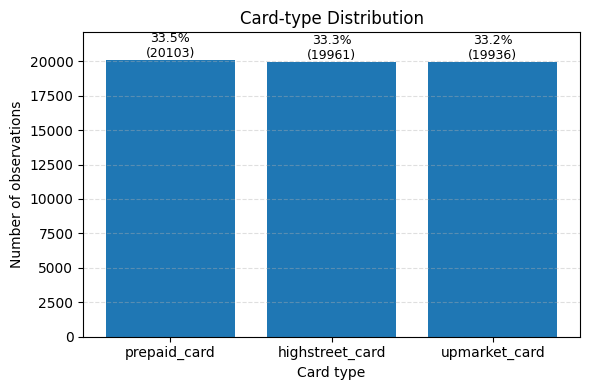


=== Missing percentage by column ===
acq_channel               0.0
app_behavioral_score      0.0
requested_credit_limit    0.0
app_channel               0.0
credit_bureau_score       0.0
stated_income             0.0
is_customer               0.0
card_type                 0.0
dtype: float64


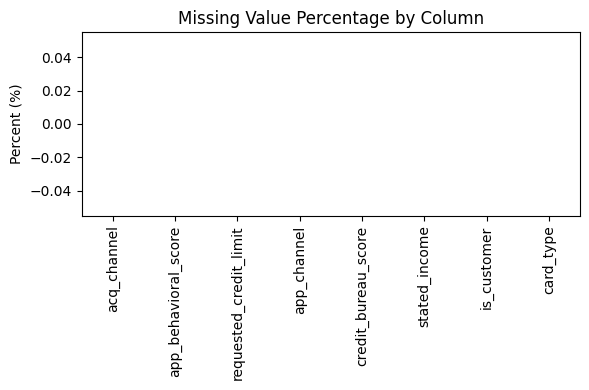

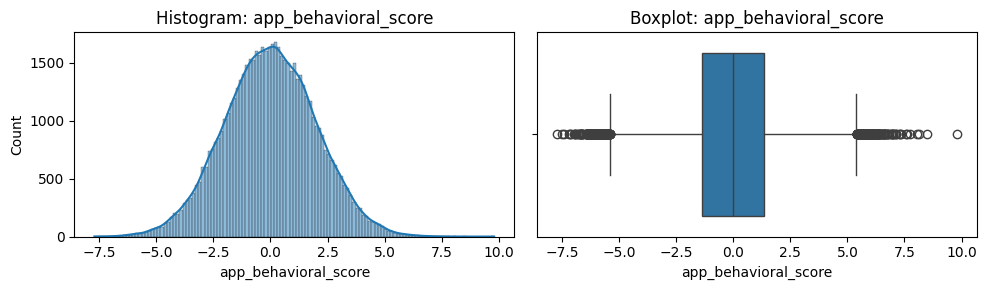

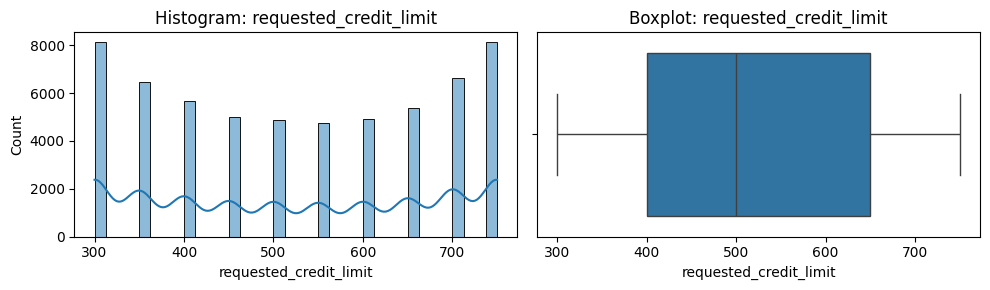

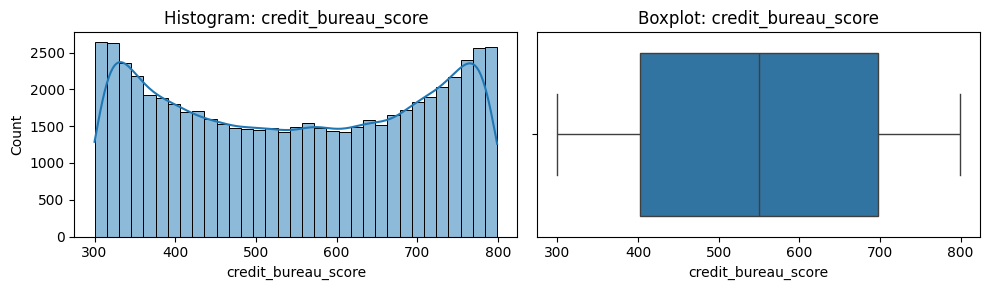

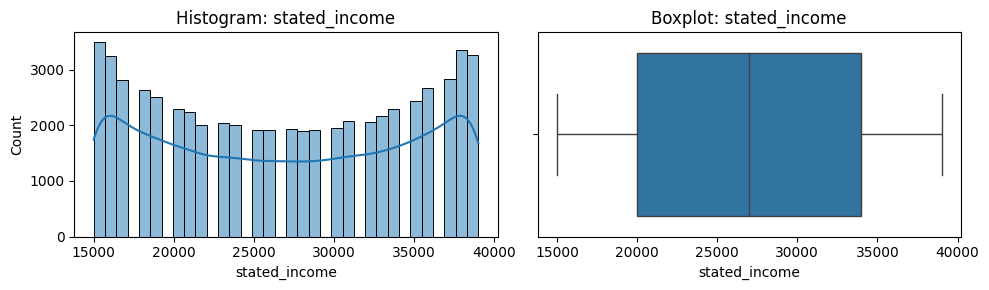


=== Outlier counts (IQR method) ===

-- k = 1.5 --
app_behavioral_score     :  386 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers

-- k = 3 --
app_behavioral_score     :    1 outliers
requested_credit_limit   :    0 outliers
credit_bureau_score      :    0 outliers
stated_income            :    0 outliers


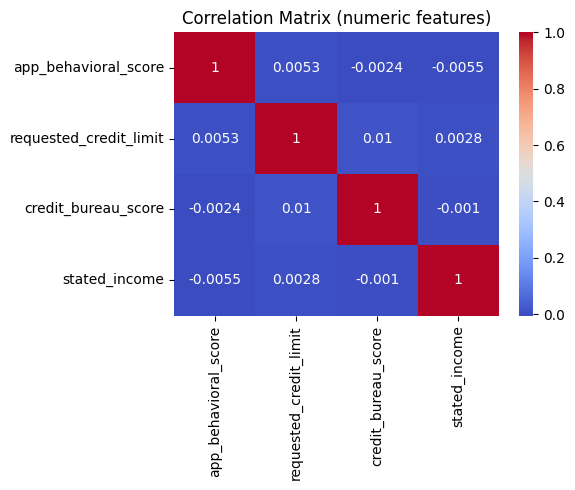

In [2]:
# Exploratory Data Analysis (Part 1)
# ----------------------------------
# This section provides a thorough inspection of the raw dataset (`data_ori`)
# WITHOUT altering it in any way. All feature engineering is performed later
# on a deep copy of the original DataFrame.

# 1 | Load the data
# ---------------------------------------------------------------------------
DATA_PATH = 'Predict_Cardtype.csv'
data_ori  = pd.read_csv('Predict_Cardtype.csv')

# 2 | Structural Overview
# ---------------------------------------------------------------------------
print("=== Preview: first 10 rows ===")
display(data_ori.head(10))

print("\n=== Dataset dimensions ===")
print(f"Rows: {data_ori.shape[0]}, Columns: {data_ori.shape[1]}")

print("\n=== Column data types ===")
print(data_ori.dtypes)

print("\n=== Non-null counts ===")
print(data_ori.isna().sum())

# 3 | Descriptive statistics
# ---------------------------------------------------------------------------
print("\n=== Descriptive statistics (numeric) ===")
display(data_ori.describe().T)

# 4 | Categorical profiling
# ---------------------------------------------------------------------------
cat_cols = ["acq_channel", "app_channel", "is_customer", "card_type"]

for col in cat_cols:
    counts   = data_ori[col].value_counts(dropna=False)
    percent  = counts / len(data_ori) * 100

    summary  = pd.DataFrame({
        "count":   counts,
        "percent": percent.round(2)         # round to 2 decimals
    })

    print(f"\n=== {col} ===")
    print(summary)

# 4a | Visualise class balance of the target variable (card_type)
# ---------------------------------------------------------------------------

# Counts and percentages
card_counts   = data_ori["card_type"].value_counts()
card_percent  = card_counts / card_counts.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(card_counts.index, card_counts.values)

# Annotations: "<pct>%\n(count)"
for bar, pct, cnt in zip(bars, card_percent, card_counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,            # slight offset above the bar
        f"{pct:.1f}%\n({cnt})",
        ha="center", va="bottom", fontsize=9
    )

# Aesthetics
ax.set_title("Card-type Distribution")
ax.set_ylabel("Number of observations")
ax.set_xlabel("Card type")
ax.set_ylim(0, card_counts.max() * 1.10)   # 10 % headroom for labels
ax.yaxis.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# 5 | Missing-value audit (table + bar chart)
# ---------------------------------------------------------------------------
missing_pct = data_ori.isna().mean().sort_values(ascending=False) * 100
print("\n=== Missing percentage by column ===")
print(missing_pct)

plt.figure(figsize=(6,4))
missing_pct.plot(kind="bar")
plt.title("Missing Value Percentage by Column")
plt.ylabel("Percent (%)")
plt.tight_layout()
plt.show()

# 6 | Distribution & outlier analysis (numeric features)
# ---------------------------------------------------------------------------
num_cols = [
    "app_behavioral_score",
    "requested_credit_limit",
    "credit_bureau_score",
    "stated_income"
]

# Histogram + boxplot loop
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.histplot(data_ori[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histogram: {col}")
    sns.boxplot(x=data_ori[col], ax=ax[1])
    ax[1].set_title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

# IQR outlier counts (k = 1.5 and 3) and extreme value lists
print("\n=== Outlier counts (IQR method) ===")
for k in [1.5, 3]:
    print(f"\n-- k = {k} --")
    for col in num_cols:
        q1, q3 = data_ori[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k * iqr, q3 + k * iqr
        mask  = (data_ori[col] < lower) | (data_ori[col] > upper)
        count = mask.sum()
        print(f"{col:25s}: {count:4d} outliers")

# 7 | Correlation analysis (numerical features)
# ---------------------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(data_ori[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

In [3]:
###############################################################################
# Feature Exploration, Engineering & Data-Frame Preparation (Part 2)
# ------------------------------------------------------------------
# All transformations are performed on a deep copy of the original data.
###############################################################################

#Please check this shit and check if standardized correctly, add feature engineering

# 0 | Create a working copy
# ---------------------------------------------------------------------------
df = data_ori.copy(deep=True)

# 1 | Explicit type casting
# ---------------------------------------------------------------------------
df["is_customer"] = df["is_customer"].astype("boolean") #Check if this is needed
df["card_type"]   = df["card_type"].astype("object")

# 2 | Imputation
# ---------------------------------------------------------------------------
# Numeric – median; categorical – mode
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

for col in cat_cols[:-1]:   # exclude target ('card_type')
    df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after imputation:")
print(df.isna().sum())

# 3 | Outlier capping (IQR, k = 1.5)
# ---------------------------------------------------------------------------
for col in num_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df[col] = df[col].clip(lower, upper)

# 4 | One-hot encode categorical predictors
# ---------------------------------------------------------------------------
predictor_cats = ["acq_channel", "app_channel", "is_customer"]
df_enc = pd.get_dummies(df, columns=predictor_cats, drop_first=True)
print("\nOne-hot encoding complete. New shape:", df_enc.shape)

# 5 | Train / test split (stratified by target)
# ---------------------------------------------------------------------------
X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("\nTrain-test split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# 6 | Scale numeric features
# ---------------------------------------------------------------------------
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
print("Numeric features scaled (zero mean, unit variance).")

# 7 | (OPTIONAL) Min-Max scaling on original data_ori for other experiments
# ---------------------------------------------------------------------------
# Note: does NOT affect df, X_train, or X_test
mms = MinMaxScaler()
data_ori_scaled = data_ori.copy()
data_ori_scaled[num_cols] = mms.fit_transform(data_ori_scaled[num_cols])

# 8 | Ready for modeling
# ---------------------------------------------------------------------------
print("\nData-preparation pipeline complete — ready for model building!")


Missing values after imputation:
acq_channel               0
app_behavioral_score      0
requested_credit_limit    0
app_channel               0
credit_bureau_score       0
stated_income             0
is_customer               0
card_type                 0
dtype: int64

One-hot encoding complete. New shape: (60000, 12)

Train-test split complete:
X_train: (42000, 11), X_test: (18000, 11)
Numeric features scaled (zero mean, unit variance).

Data-preparation pipeline complete — ready for model building!


/tmp/ipython-input-3-3625829693.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [4]:
###############################################################################
# 3 | Train-Test Splitting & Scaling
# ----------------------------------
# This step separates predictors from the target, performs a stratified split
# (preserving class balance), and applies standardization to numeric features.
###############################################################################

# 1 | Split into features and target
# ---------------------------------------------------------------------------
X = df_enc.drop("card_type", axis=1)
y = df_enc["card_type"]

# 2 | Stratified train-test split
# ---------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,         # 70% train, 30% test
    stratify=y,             # ensures proportional card_type representation
    random_state=42         # reproducibility
)

print("\nTrain-test split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True).round(3)}")

# 3 | Standardize numeric features (zero mean, unit variance)
# ---------------------------------------------------------------------------
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Numeric features scaled (standardization complete).")



Train-test split complete:
X_train: (42000, 11), X_test: (18000, 11)
y_train distribution:
card_type
prepaid_card       0.335
highstreet_card    0.333
upmarket_card      0.332
Name: proportion, dtype: float64
Numeric features scaled (standardization complete).



Cross-validated Accuracy (train only): 0.7675

Classification Report (CV on training set):
                 precision    recall  f1-score   support

highstreet_card     0.7557    0.7555    0.7556     13973
   prepaid_card     0.7744    0.7754    0.7749     14072
  upmarket_card     0.7723    0.7715    0.7719     13955

       accuracy                         0.7675     42000
      macro avg     0.7675    0.7675    0.7675     42000
   weighted avg     0.7675    0.7675    0.7675     42000


Confusion Matrix (CV on training set):


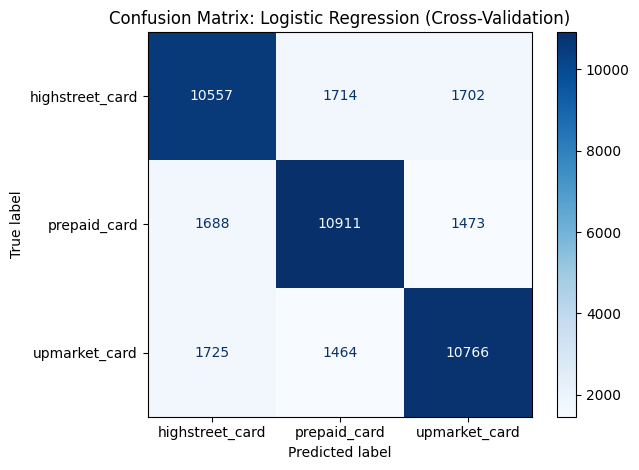

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# 1 | Initialize logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# 2 | Stratified 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 3 | Cross-validated predictions on training set
y_train_pred = cross_val_predict(logreg, X_train, y_train, cv=cv)

# 4 | Evaluate performance
cv_acc = accuracy_score(y_train, y_train_pred)
print(f"\nCross-validated Accuracy (train only): {cv_acc:.4f}")

print("\nClassification Report (CV on training set):")
print(classification_report(y_train, y_train_pred, digits=4))

print("\nConfusion Matrix (CV on training set):")
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression (Cross-Validation)")
plt.grid(False)
plt.tight_layout()
plt.show()



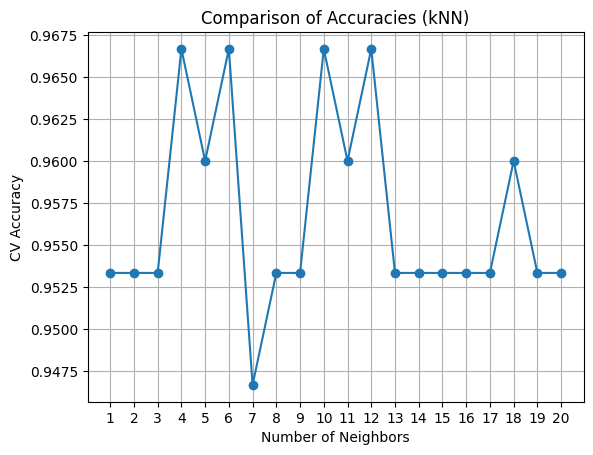

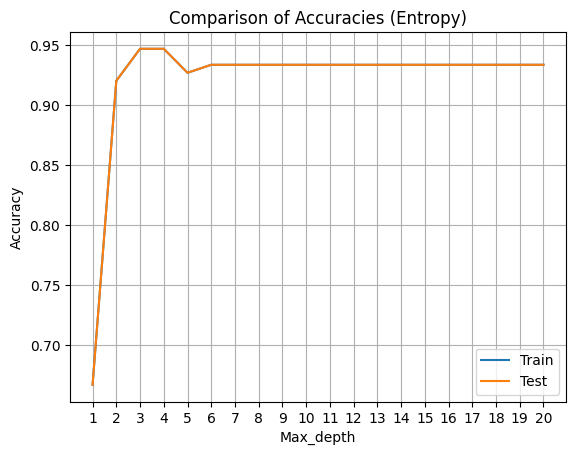

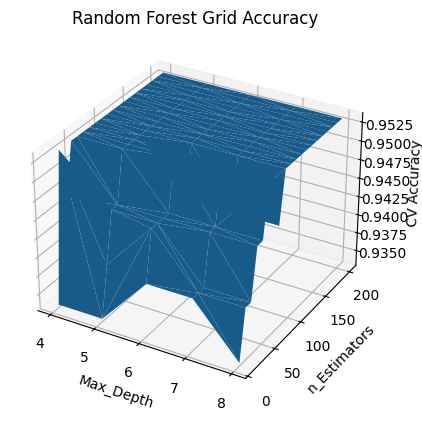

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


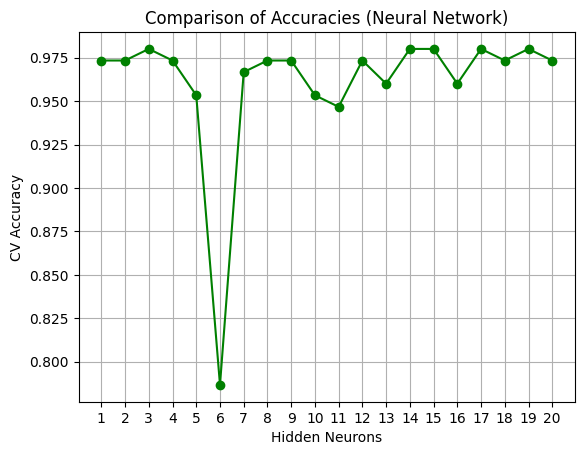

Logistic Regression CV Accuracy: 0.940 ± 0.063


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# ---- Replace this with your actual dataset ----
# df = pd.read_csv("your_clean_data.csv")
# X = df.drop("card_type", axis=1)
# y = df["card_type"]

# Simulated X/y for syntax testing (REMOVE THIS in final version)
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Normalize
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# --------------------------------------------------------
# KNN: Accuracy vs. k
# --------------------------------------------------------
knn_accuracies = []
for k in range(1, 21):
    knnmodel = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knnmodel, X_scaled, y, cv=cv, scoring='accuracy')
    knn_accuracies.append(scores.mean())

plt.figure()
plt.plot(range(1, 21), knn_accuracies, marker='o')
plt.title("Comparison of Accuracies (kNN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("CV Accuracy")
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

# --------------------------------------------------------
# Decision Tree: Accuracy vs. max_depth (Entropy)
# --------------------------------------------------------
tree_acc = np.zeros((2, 20))
for depth in range(1, 21):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    scores_train = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    tree_acc[0, depth-1] = scores_train.mean()

    scores_test = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    tree_acc[1, depth-1] = scores_test.mean()

plt.figure()
plt.plot(range(1, 21), tree_acc[0], label="Train")
plt.plot(range(1, 21), tree_acc[1], label="Test")
plt.title("Comparison of Accuracies (Entropy)")
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------
# Random Forest: Accuracy vs. max_depth and n_estimators
# --------------------------------------------------------
rf_acc = np.zeros((4, 100))  # max_depth, n_estimators, acc_train, acc_test
ntrees = (np.arange(20)+1)*10
mdepth = np.linspace(4, 8, 5)
row = 0

for d in mdepth:
    for n in ntrees:
        model = RandomForestClassifier(max_depth=int(d), n_estimators=n, random_state=42)
        scores_train = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
        rf_acc[2, row] = scores_train.mean()

        scores_test = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
        rf_acc[3, row] = scores_test.mean()

        rf_acc[0, row] = d
        rf_acc[1, row] = n
        row += 1

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(rf_acc[0], rf_acc[1], rf_acc[3], linewidth=0.2, antialiased=True)
ax.set_xlabel('Max_Depth')
ax.set_ylabel('n_Estimators')
ax.set_zlabel('CV Accuracy')
plt.title('Random Forest Grid Accuracy')
plt.show()

# --------------------------------------------------------
# Neural Network (MLP): Accuracy vs. Hidden Neurons
# --------------------------------------------------------
mlp_acc = []
for n in range(1, 21):
    mlp = MLPClassifier(hidden_layer_sizes=(n,), solver='lbfgs', max_iter=1000, random_state=42)
    scores = cross_val_score(mlp, X_scaled, y, cv=cv, scoring='accuracy')
    mlp_acc.append(scores.mean())

plt.figure()
plt.plot(range(1, 21), mlp_acc, marker='o', color='green')
plt.title("Comparison of Accuracies (Neural Network)")
plt.xlabel("Hidden Neurons")
plt.ylabel("CV Accuracy")
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

# --------------------------------------------------------
# Logistic Regression (no tuning needed)
# --------------------------------------------------------
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg_scores = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='accuracy')
print("Logistic Regression CV Accuracy: %.3f ± %.3f" % (logreg_scores.mean(), logreg_scores.std()))
